# Evaluation & Severity

Import library & Path

In [5]:
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parent
sys.path.append(str(PROJECT_ROOT))

import torch
import numpy as np
import matplotlib.pyplot as plt
from src.datasets import TomatoLeafDataset
from src.models import UNet

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Load Dataset (test only)

In [6]:
test_dataset = TomatoLeafDataset(
    data_root=PROJECT_ROOT / "data",
    split_file=PROJECT_ROOT / "data" / "splits.json",
    split="test"
)
print("Test samples:", len(test_dataset))

Test samples: 30


Load trained models

In [10]:
leaf_model = UNet(in_channels=3, out_channels=1).to(device)
disease_model = UNet(in_channels=3, out_channels=1).to(device)

leaf_model.load_state_dict(torch.load(PROJECT_ROOT/"checkpoints/leaf_best.pth", map_location=device))
disease_model.load_state_dict(torch.load(PROJECT_ROOT/"checkpoints/disease_best.pth", map_location=device))

leaf_model.eval()
disease_model.eval()

UNet(
  (enc1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (enc3): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(128, 256, kernel_size=

Prediction function

In [11]:
@torch.no_grad()
def predict_masks(img):
    img = img.unsqueeze(0).to(device)

    leaf_pred = torch.sigmoid(leaf_model(img)) > 0.5
    img_masked = img * leaf_pred

    disease_pred = torch.sigmoid(disease_model(img_masked)) > 0.5

    return leaf_pred.squeeze(), disease_pred.squeeze()

In [12]:
def visualize_result(img, leaf_gt, disease_gt, leaf_pred, disease_pred, title=""):
    img = img.permute(1, 2, 0).cpu().numpy()

    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    ax[0].imshow(img)
    ax[0].imshow(leaf_gt.squeeze(), alpha=0.4, cmap="Greens")
    ax[0].set_title("GT Leaf")
    ax[0].axis("off")

    ax[1].imshow(img)
    ax[1].imshow(disease_gt.squeeze(), alpha=0.4, cmap="Reds")
    ax[1].set_title("GT Disease")
    ax[1].axis("off")

    ax[2].imshow(img)
    ax[2].imshow(disease_pred.squeeze(), alpha=0.4, cmap="Reds")
    ax[2].set_title("Pred Disease")
    ax[2].axis("off")

    plt.suptitle(title)
    plt.show()


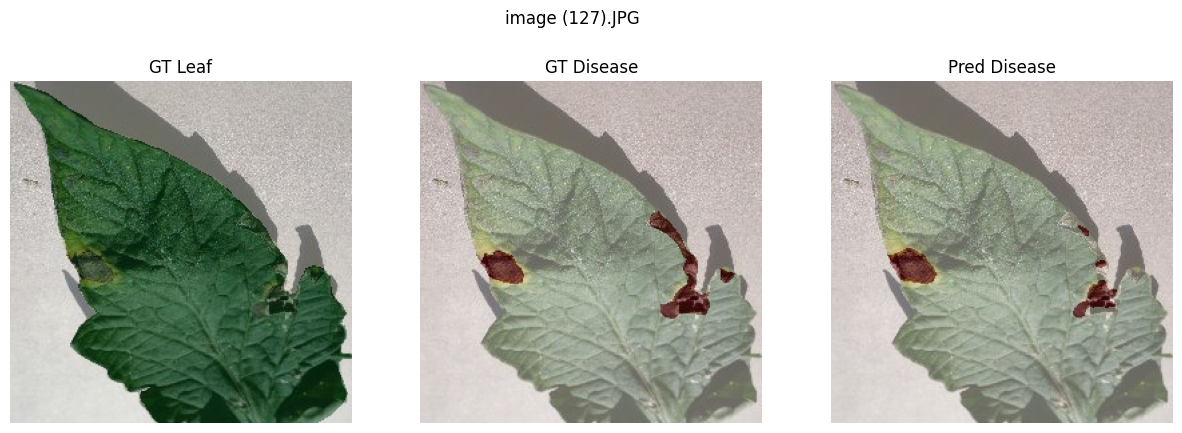

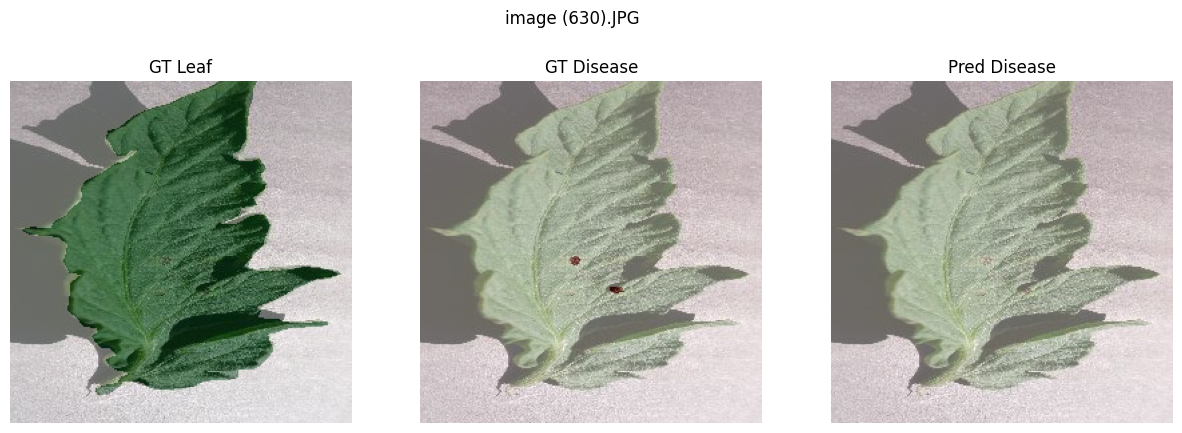

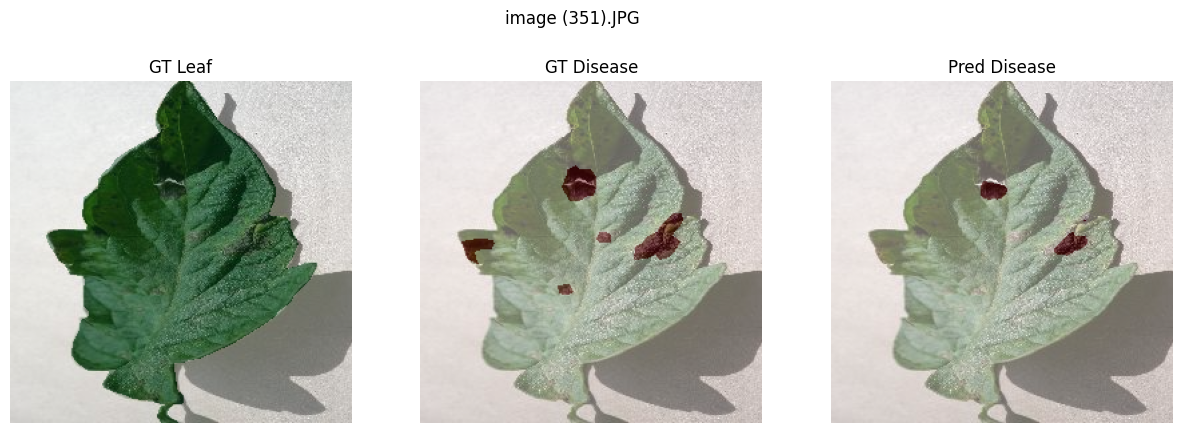

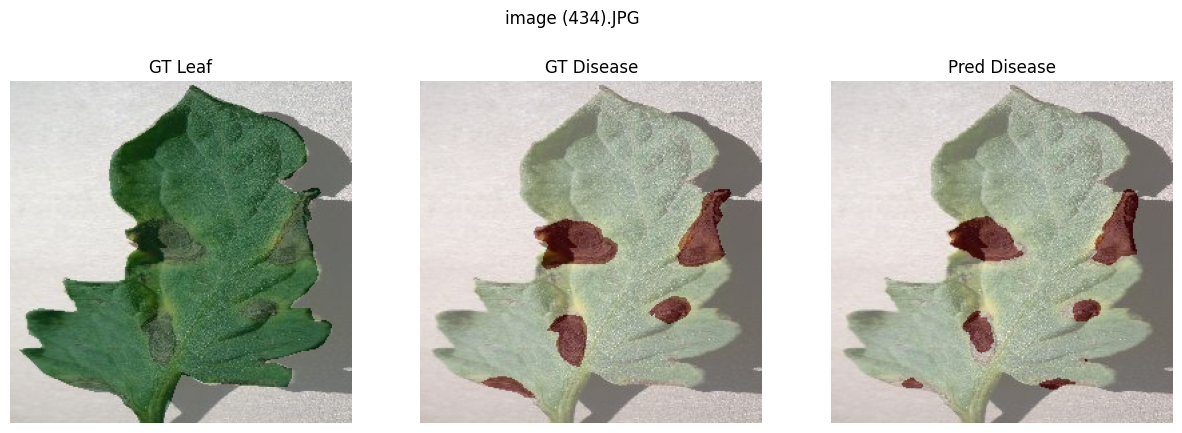

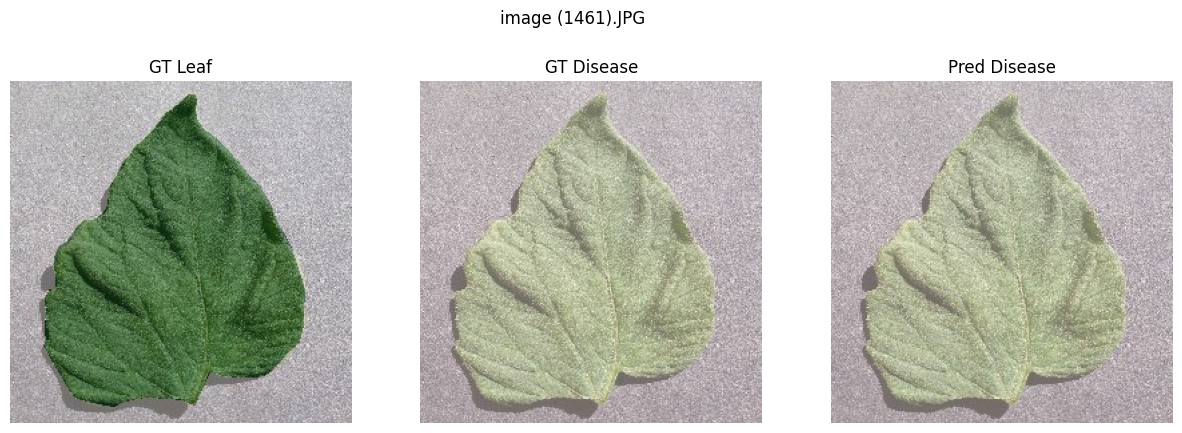

In [13]:
import random

for idx in random.sample(range(len(test_dataset)), 5):
    img, leaf_gt, disease_gt, meta = test_dataset[idx]
    leaf_pred, disease_pred = predict_masks(img)

    visualize_result(
        img, leaf_gt, disease_gt,
        leaf_pred.cpu(), disease_pred.cpu(),
        title=meta["filename"]
    )


In [14]:
def compute_severity(leaf_mask, disease_mask):
    leaf_area = leaf_mask.sum()
    disease_area = disease_mask.sum()
    return (disease_area / leaf_area).item() if leaf_area > 0 else 0.0


In [15]:
gt_severity = []
pred_severity = []

for img, leaf_gt, disease_gt, _ in test_dataset:
    leaf_pred, disease_pred = predict_masks(img)

    gt_severity.append(
        compute_severity(leaf_gt, disease_gt)
    )
    pred_severity.append(
        compute_severity(leaf_pred.cpu(), disease_pred.cpu())
    )


Hasil severity

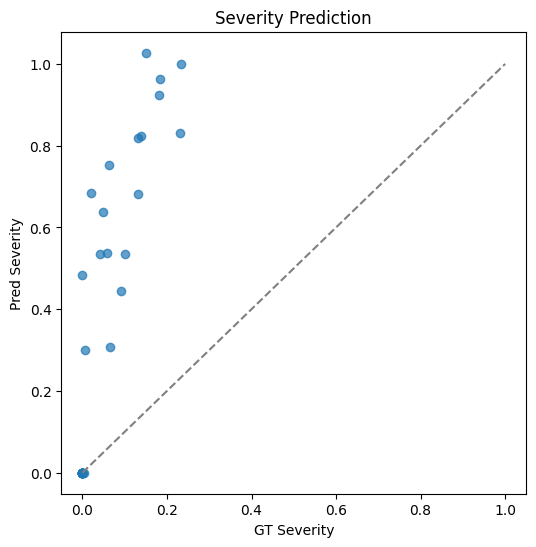

In [16]:
plt.figure(figsize=(6,6))
plt.scatter(gt_severity, pred_severity, alpha=0.7)
plt.plot([0,1], [0,1], "--", color="gray")
plt.xlabel("GT Severity")
plt.ylabel("Pred Severity")
plt.title("Severity Prediction")
plt.show()


In [17]:
import numpy as np

corr = np.corrcoef(gt_severity, pred_severity)[0,1]
print("Severity correlation:", corr)


Severity correlation: 0.8652074282030925


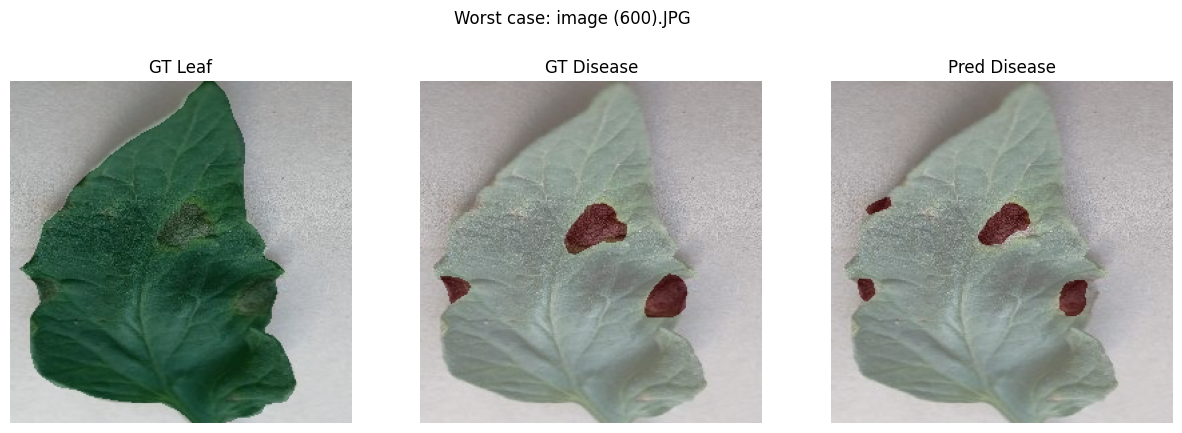

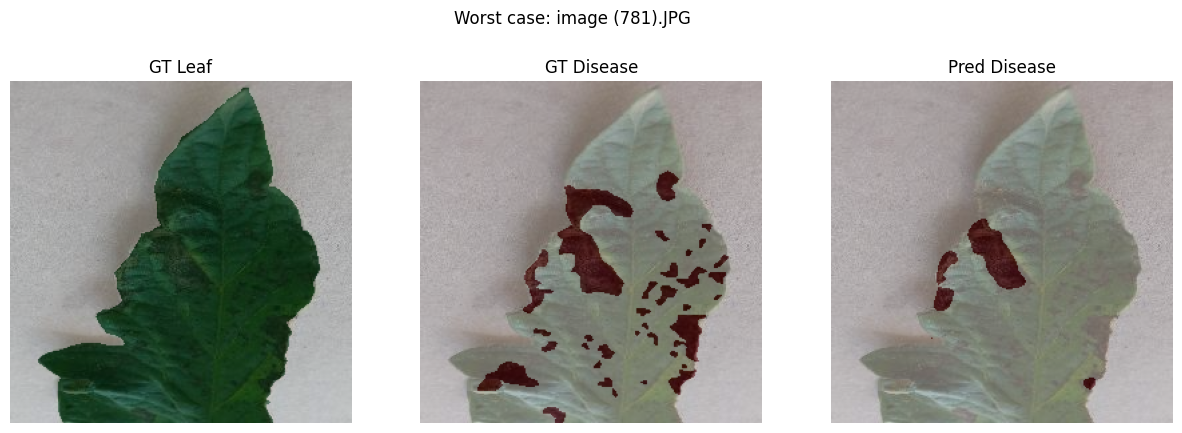

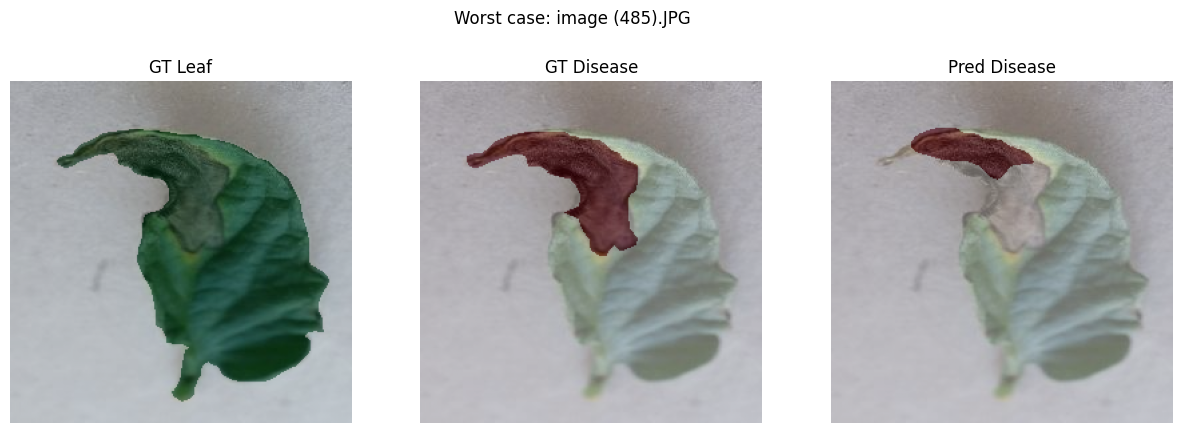

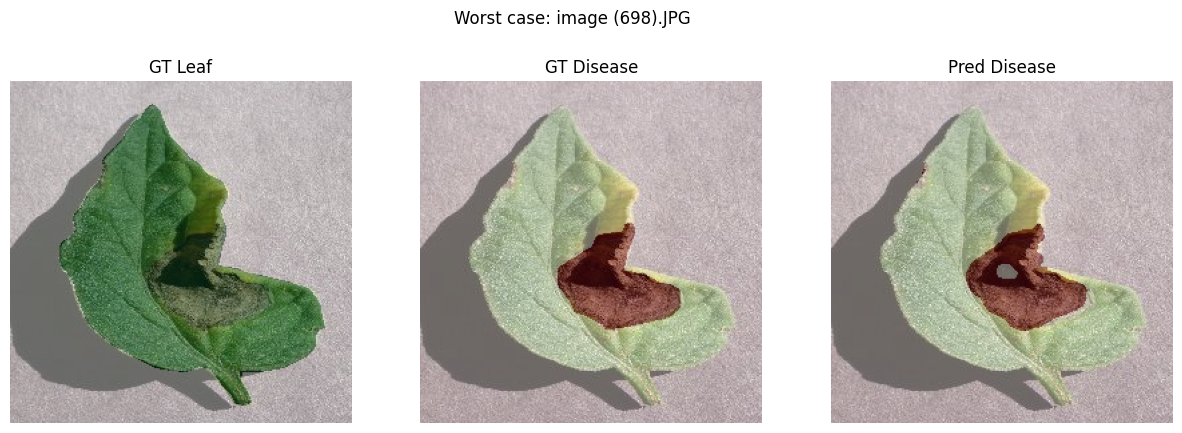

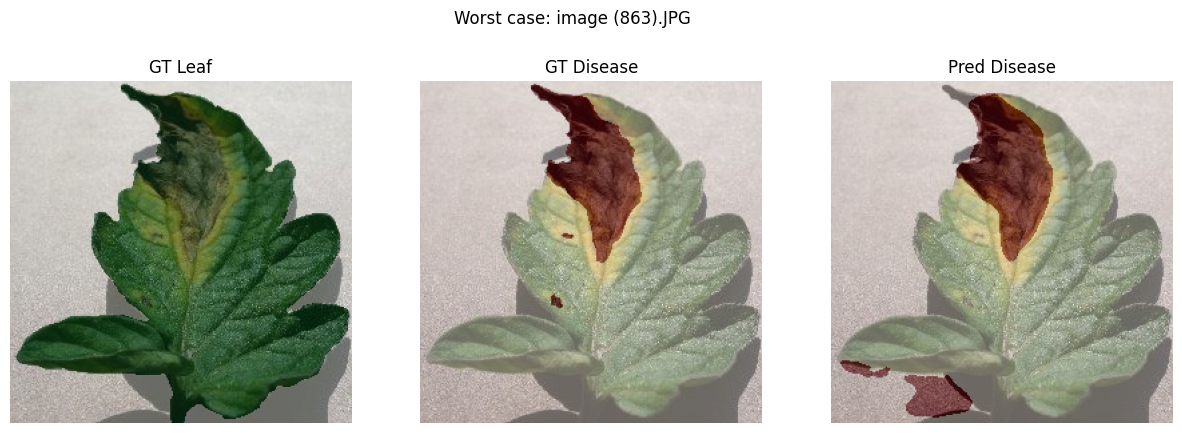

In [18]:
errors = np.abs(np.array(gt_severity) - np.array(pred_severity))
worst_idx = np.argsort(errors)[-5:]

for idx in worst_idx:
    img, leaf_gt, disease_gt, meta = test_dataset[idx]
    leaf_pred, disease_pred = predict_masks(img)

    visualize_result(
        img, leaf_gt, disease_gt,
        leaf_pred.cpu(), disease_pred.cpu(),
        title=f"Worst case: {meta['filename']}"
    )
